# Wind Energy Production Prediction

In this notebook, the process of coming to the final model is displayed. It will also explain why we made certain decisions.

## Importing packages 

Importing the needed packages. 

In [27]:
import numpy as np
import optuna
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.utils import shuffle

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print(f"numpy version: {np.__version__}")
print(f"optuna version: {optuna.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"tensorflow version: {tf.__version__}")

numpy version: 2.0.2
optuna version: 4.1.0
pandas version: 2.2.3
matplotlib version: 3.10.0
scikit-learn version: 1.6.1
tensorflow version: 2.18.0


## Loading Data

In this section, we will load the cleaned dataset, which contains both weather data and wind energy production data. This dataset will be used for model training.

In [28]:
df = pd.read_csv('../data/Model/production_wind_data.csv')
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
51261,2023-11-07 22:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,2849000,2849000,1.297095,...,8,92,7,0,1,0,0,0,9.595833,7.799861
51319,2023-11-10 08:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,2796000,2796000,1.272962,...,8,88,7,0,1,0,0,0,7.395833,7.799861
2524,2021-04-16 04:00:00,Nederland,Wind,Hour,UTC,Providing,Current,98631,98631,0.026439,...,1,94,5,0,0,0,0,0,6.462500,6.649583
41985,2022-10-17 10:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,1291249,1291249,0.587880,...,8,95,7,0,1,0,0,0,15.495833,13.050269
33709,2021-11-06 14:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,2152000,2152000,0.979763,...,8,81,5,0,0,0,0,0,9.716667,7.383611


Since the dataset contains some offshore wind data, we will remove those entries to ensure that only mainland wind data is included. 

Offshore wind data could confuse the model since the weather data is from the center of the Netherlands(de Bilt).

In [29]:
df = df[df['type'] == 'Wind']
df.sample(5)

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
6560,2021-10-01 08:00:00,Nederland,Wind,Hour,UTC,Providing,Current,3685357,3685357,0.873583,...,8,70,5,0,0,0,0,0,13.479167,11.605376
569,2021-01-24 17:00:00,Nederland,Wind,Hour,UTC,Providing,Current,170783,170783,0.047579,...,8,84,5,0,0,0,0,0,2.370833,3.376747
3508,2021-05-27 04:00:00,Nederland,Wind,Hour,UTC,Providing,Current,2256085,2256085,0.586066,...,8,95,7,0,1,0,0,0,10.450000,11.212500
24572,2023-10-21 20:00:00,Nederland,Wind,Hour,UTC,Providing,Current,4065258,4065258,0.669882,...,8,74,5,0,0,0,0,0,13.029167,13.213710
9328,2022-01-24 16:00:00,Nederland,Wind,Hour,UTC,Providing,Current,2146,2146,0.000471,...,8,76,5,0,0,0,0,0,4.479167,5.299731


## Predictions

To start the predictions phase, we will select the features that best fit the target. This way, we give the model the best chance to accurately predict the target.

### Feature Selection

In the heatmap displayed in the EDA, we identified the columns that best correlate with the target variable. These columns will be used as features in the model.

In [30]:
# Features and target selection
features = ['WindSpeedAvg60min', 'WindGust','WindSpeedAvg10min', 'WindDirection', 'Temperature', 'Pressure']
target = 'capacity'

Next, we will be scaling the data. Scaling the data improves the stability of the training process by ensuring that the features contribute equally during training.

In [31]:
# Scale the data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform features and target
scaled_features = feature_scaler.fit_transform(df[features])
scaled_target = target_scaler.fit_transform(df[[target]])

# Combine scaled features and target
scaled_data = np.hstack([scaled_features, scaled_target])


Next, we will be creating sequences. This step is crucial for time series forecasting as it allows the model to look back upon data from earlier time steps. By creating sequences, we enable the model to capture temporal dependencies and patterns in the data, which can significantly improve the accuracy of our predictions.

In this context, a sequence is a subset of the data that includes a specified number of previous time steps (e.g., the past 24 hours) to predict the next time step. This approach helps the model understand how past observations influence future values.

In [32]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 24  # Use past 24 hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

Next, we split the data into training and testing sets using an 80/20 split, where 80% of the data is used for training and 20% is used for testing. This ensures that the model has enough data to learn from while also having a separate set of data to evaluate its performance.

In [33]:
# # Shuffle the dataset
# X, y = shuffle(X, y, random_state=42)

# Split the dataset with a random state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Modeling
To start of the modeling section. We decides to try a couple of different models and improve on the model with the most potential. 

#### LSTM

To start off with LSTM. LSTM stands for Long Short-Term Memory. It is a deep learning model that is comparable to an ARIMA model. While ARIMA is not suited for long-term predictions beyond 6 months, LSTM is more suited for these types of time series predictions.

> https://www.geeksforgeeks.org/understanding-of-lstm-networks/

> other source my internship research document

In [34]:
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(1)
])
# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


This LSTM model has 5 layers, with the last one being an output layer.

It includes:
- 2 LSTM layers: These layers contain memory cells that allow the model to maintain information over long periods. This makes the LSTM suitable for predictions over data with seasonal trends.
- 2 Dropout layers: These layers randomly drop units during training, forcing the model to learn redundant representations. This improves the model's ability to generalize to new data and prevents overfitting.


In [35]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.35,
    verbose=0
)

# Calculate R2 score for train data
train_predictions = model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)

# Calculate R2 score for test data
predictions = model.predict(X_test)
test_r2 = r2_score(y_test, predictions)

print(f"Train R2 Score: {train_r2}")
print(f"Test R2 Score: {test_r2}")

657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Train R2 Score: 0.8513090146113316
Test R2 Score: 0.844042978203855


The initial model performs quite well and does not appear to be overfitted. Next, we will examine the training performance over all epochs.

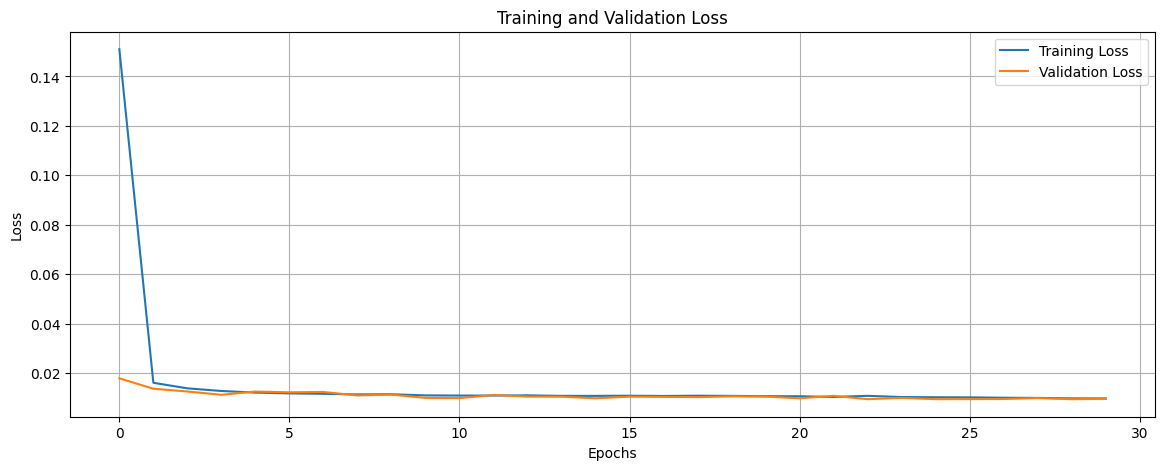

In [36]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The training and validation loss curves are close to each other, indicating that the model is not overfitting and can generalize well to new data. Overfitting occurs when a model performs well on training data but poorly on validation data, typically seen when the training loss is much lower than the validation loss. In our case, the close alignment of these curves suggests that the model has learned the underlying patterns without memorizing the training data.

The use of dropout layers in the model architecture helps prevent overfitting by randomly dropping units during training, forcing the model to learn redundant representations. This improves the model's ability to generalize to new data.

Overall, the training and validation loss curves indicate that the model performs well and can generalize effectively to unseen data.

Next, we will print a plot that will show the predicte values against the actual values. 

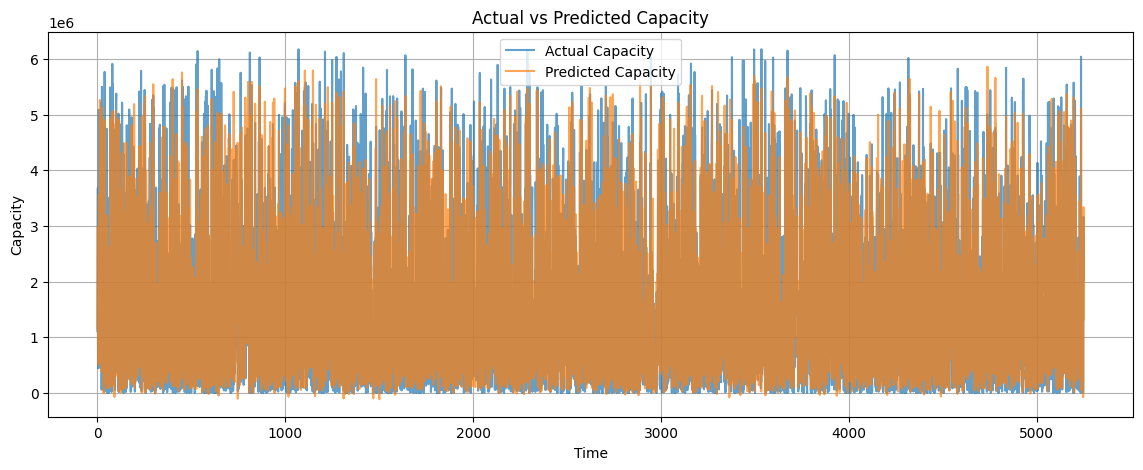

In [37]:
# Inverse transform predictions and actual values
predicted_capacity = target_scaler.inverse_transform(predictions)
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot Predictions vs Actual Values
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

From this, you can see that it does predict the trends very well. It predicts lower than the actual values, but it does show the same waves as the actual values.

#### RNN

RNNs (Recurrent Neural Networks) are designed to recognize patterns in sequences of data, making them ideal for tasks like time series forecasting. Unlike traditional neural networks, RNNs maintain a memory of previous inputs through directed cycles in their connections.

While LSTMs (Long Short-Term Memory) are a type of RNN for handling long-term dependencies, standard RNNs can still be effective for certain time series data. RNNs process input data step-by-step, updating a hidden state that captures information from previous steps.

We'll use a simple RNN model to predict wind energy production from past weather data and compare its performance with an LSTM model to see which is better for our task.

> my internship research document 
> https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/ 

In [38]:
# Build the RNN model
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    SimpleRNN(256),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn_model.summary()


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_27 (SimpleRNN)       │ (None, 24, 128)        │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_28 (SimpleRNN)       │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,097 (453.50 KB)

 Trainable params: 116,097 (453.50 KB)

 Non-trainable params: 0 (0.00 B)

The structure of the RNN model is similar to that of the LSTM model. The RNN model has 5 layers:

* 2 SimpleRNN layers: Recognize patterns in sequences.
* 2 Dropout layers: Prevent overfitting by randomly dropping units during training.
* 1 Dense output layer: Produces the final prediction.

RNNs process input data step-by-step, maintaining a hidden state with information from previous steps. We'll use this RNN model to predict wind energy production from past weather data and compare it with an LSTM model.

In [39]:
# Train the RNN model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
# Make predictions using the RNN model
rnn_predictions = rnn_model.predict(X_test)
rnn_test_r2 = r2_score(y_test, rnn_predictions)

rnn_train_predictions = rnn_model.predict(X_train)

rnn_train_r2 = r2_score(y_train, rnn_train_predictions)

print(f"RNN Train R2 Score: {rnn_train_r2}")
print(f"RNN Test R2 Score: {rnn_test_r2}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RNN Train R2 Score: 0.832696460873356
RNN Test R2 Score: 0.829715789942364


The initial training performs well. The R² score is slightly higher than the LSTM, and the difference between test and train scores indicates that it is not overfitted. 

Next, we will be looking at the training loss versus validation loss. 

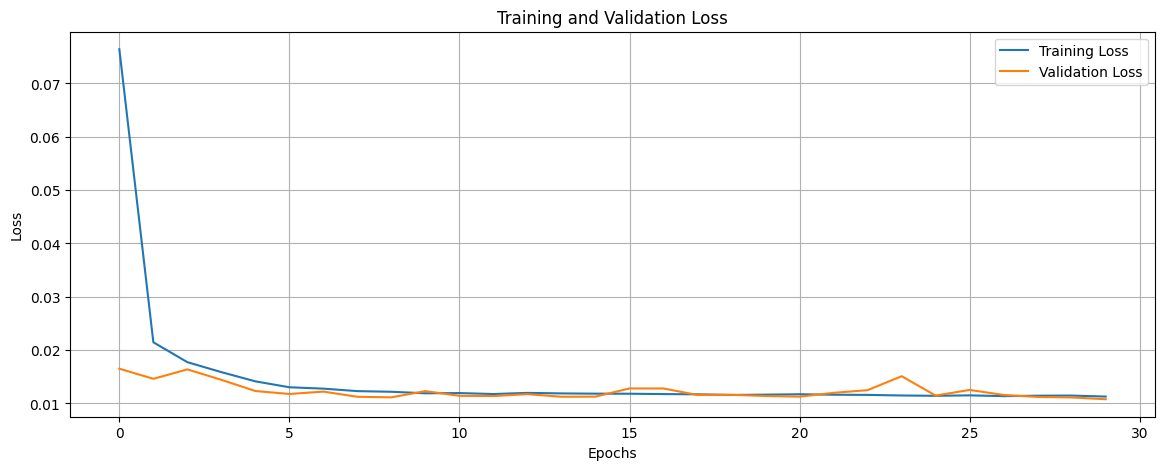

In [40]:
# Inverse transform the predictions
predicted_rnn_capacity = target_scaler.inverse_transform(rnn_predictions)
actual_rnn_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The lines of the training and validation loss are very close to each other, meaning it is not overfitted.

Next, we will look at the predicted versus actual values.

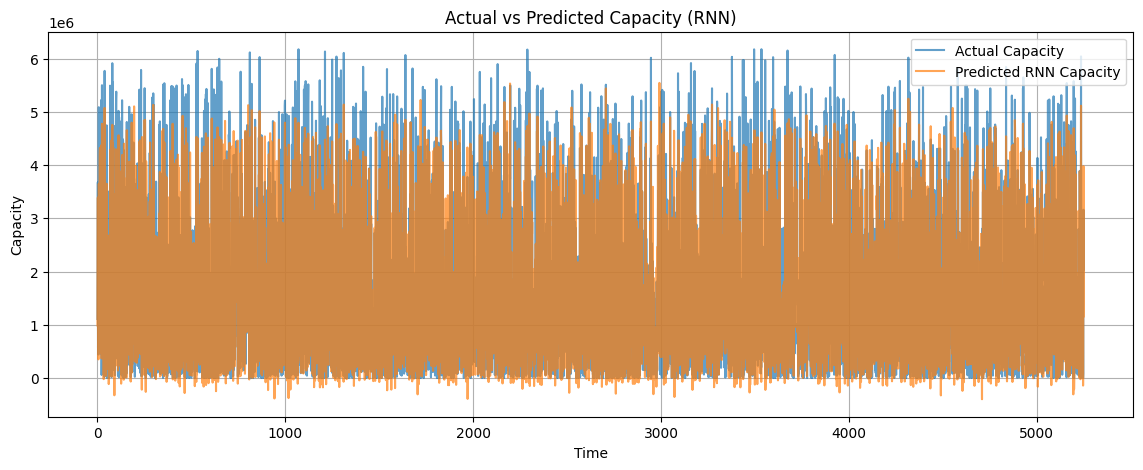

In [41]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

The actual versus predicted values seem to be predicting better. It still shows that the predicted values are lower than the actual values, but they are closer to each other.

##### Comparisons

Because it is really hard to see which model preforms the best we will be comparing the two next to eachother. staring of with the R².

In [42]:
print(f"RNN Train R2 Score: {rnn_train_r2}")
print(f"RNN Test R2 Score: {rnn_test_r2}")

print(f"LSTM Train R2 Score: {train_r2}")
print(f"LSTM Test R2 Score: {test_r2}")

RNN Train R2 Score: 0.832696460873356
RNN Test R2 Score: 0.829715789942364
LSTM Train R2 Score: 0.8513090146113316
LSTM Test R2 Score: 0.844042978203855


The LSTM has a higher accuracy score then the RNN. The RNN as less of a difference between the test and train R² which would say that teh RNN is less overfitted. 

the difference between test and train R² is however for both models very small. 

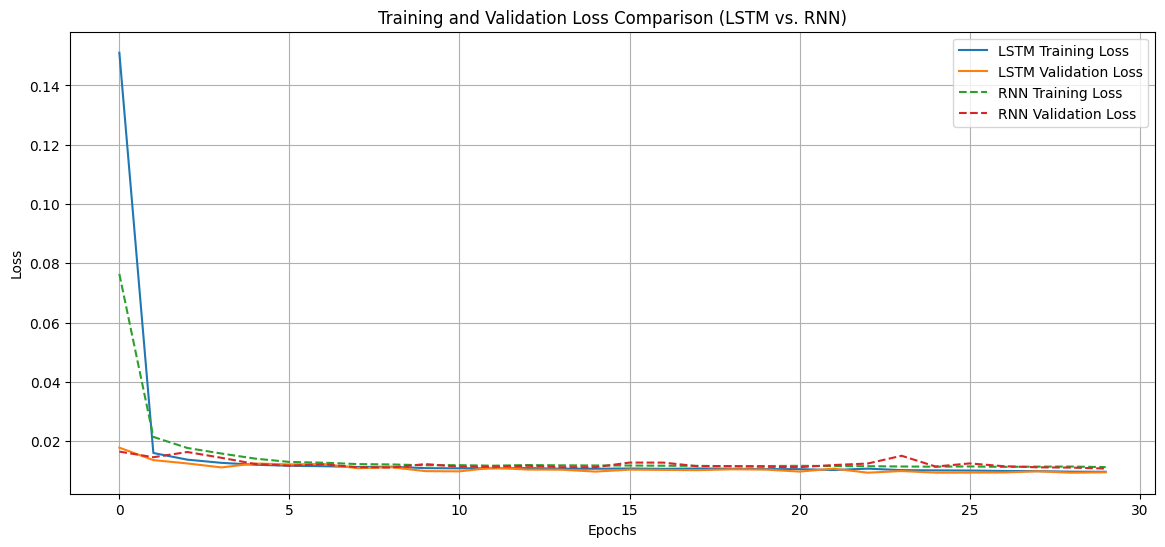

In [59]:
# Plot training and validation loss for both LSTM and RNN
plt.figure(figsize=(14, 6))

# LSTM Loss
plt.plot(history.history['loss'], label='LSTM Training Loss')
plt.plot(history.history['val_loss'], label='LSTM Validation Loss')

# RNN Loss
plt.plot(rnn_history.history['loss'], label='RNN Training Loss', linestyle='dashed')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss', linestyle='dashed')

# Titles and labels
plt.title('Training and Validation Loss Comparison (LSTM vs. RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


the training and validation los of both models are very close to eachother. the LSTM model does seem more smooth this would mean that te LSTM is more stable then the rnn. 

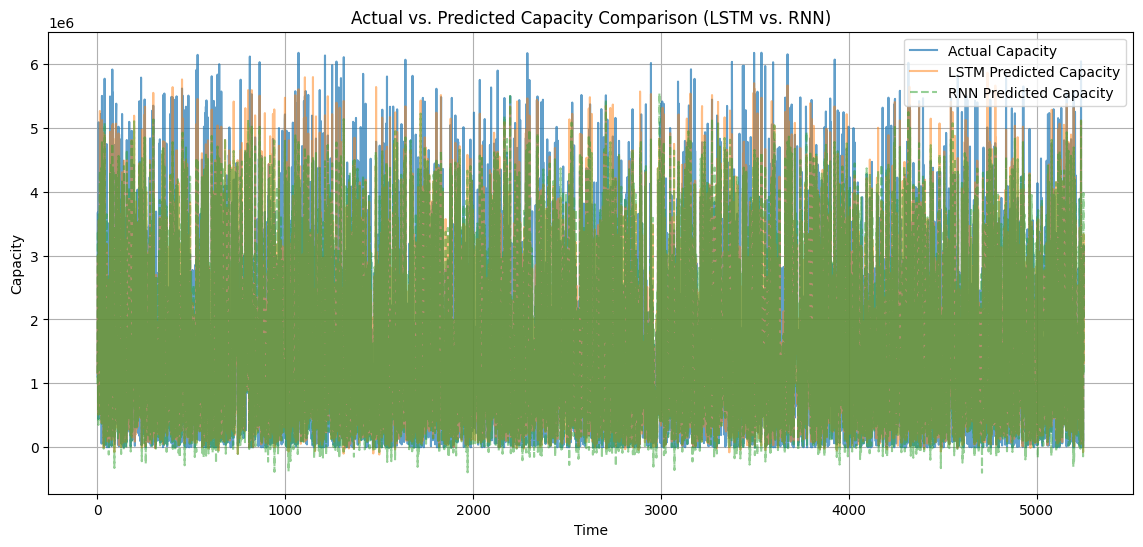

In [44]:
# Plot Actual vs. Predicted Capacity for both LSTM and RNN
plt.figure(figsize=(14, 6))

# Actual values
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)

# LSTM Predictions
plt.plot(predicted_capacity, label='LSTM Predicted Capacity', alpha=0.5)

# RNN Predictions
plt.plot(predicted_rnn_capacity, label='RNN Predicted Capacity', alpha=0.5, linestyle='dashed')

# Titles and labels
plt.title('Actual vs. Predicted Capacity Comparison (LSTM vs. RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()


There is probavly an other model that might preform better so just to be safe we decided to look for another model. this is where we cam across GRU. 

### GRU

A GRU (Gated Recurrent Unit) uses two gates:

* The reset gate 
* The update gate

To manage information flow.

These gates selectively update the hidden state at each time step, controlling what information is kept or discarded.

https://www.geeksforgeeks.org/gated-recurrent-unit-networks/ 

In [45]:
GRU_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
GRU_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
GRU_model.summary()

c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_23 (GRU)                    │ (None, 24, 128)        │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,537 (349.75 KB)

 Trainable params: 89,537 (349.75 KB)

 Non-trainable params: 0 (0.00 B)

The structure of the GRU model is similar to that of the LSTM and the RNN. The GRU model has 5 layers:

* 2 GRU layers: Recognize patterns in sequences.
* 2 Dropout layers: Prevent overfitting by randomly dropping units during training.
* 1 Dense output layer: Produces the final prediction.

In [46]:
# Train the RNN model
GRU_history = GRU_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)
# Make predictions using the RNN model
GRU_predictions = GRU_model.predict(X_test)

# Inverse transform the predictions
predicted_GRU_capacity = target_scaler.inverse_transform(GRU_predictions)

GRU_test_r2 = r2_score(y_test, GRU_predictions)
GRU_train_predictions = GRU_model.predict(X_train)
GRU_train_r2 = r2_score(y_train, GRU_train_predictions)

print(f"GRU Train R2 Score: {GRU_train_r2}")
print(f"GRU Test R2 Score: {GRU_test_r2}")

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
GRU Train R2 Score: 0.8780249627844041
GRU Test R2 Score: 0.8707821550585937


The basic model her has a higher accuracy score then the LSTM and RNN. it is also not overfited. 

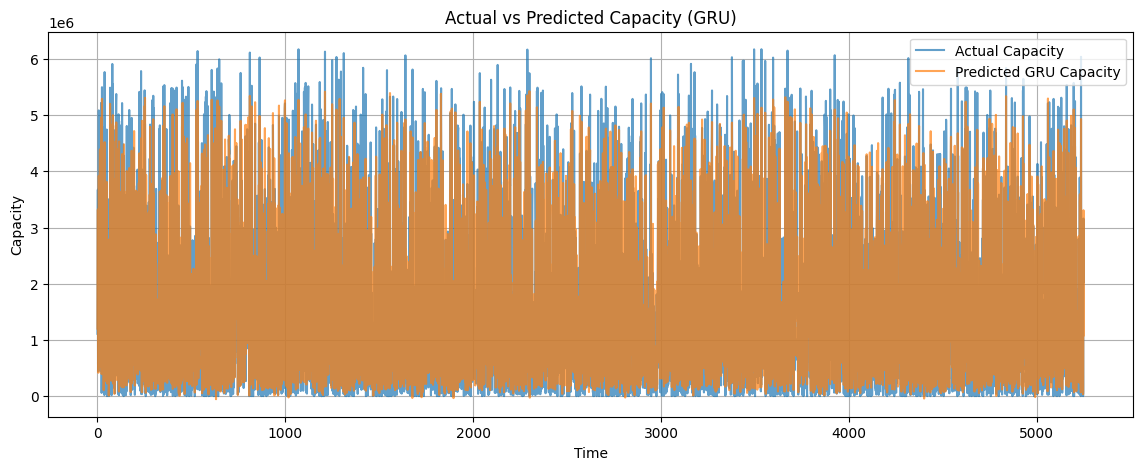

In [47]:
# Plot Predictions vs Actual Values for GRU
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_GRU_capacity, label='Predicted GRU Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (GRU)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

It seems to predict the actually values pretty well. according to the plot above here. 

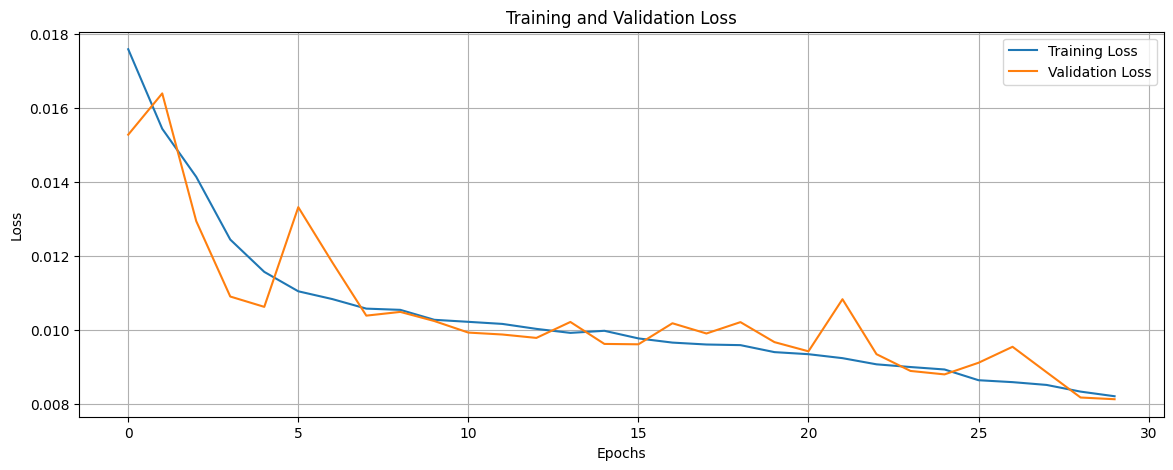

In [48]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(GRU_history.history['loss'], label='Training Loss')
plt.plot(GRU_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The validation los and training loss are very close to eachother which means it is not overfitted. however the validation los is not really a smooth line which could indicate that the model is unstable. 

#### Comparing all three

to really get a good idea of which model is best we will compare all three to eachother. 

In [49]:
# Print additional metrics
print(f"GRU Train R2 Score: {GRU_train_r2}")
print(f"GRU Test R2 Score: {GRU_test_r2}")
print(f"RNN Train R2 Score: {rnn_train_r2}")
print(f"RNN Test R2 Score: {rnn_test_r2}")
print(f"LSTM Train R2 Score: {train_r2}")
print(f"LSTM Test R2 Score: {test_r2}")


GRU Train R2 Score: 0.8780249627844041
GRU Test R2 Score: 0.8707821550585937
RNN Train R2 Score: 0.832696460873356
RNN Test R2 Score: 0.829715789942364
LSTM Train R2 Score: 0.8513090146113316
LSTM Test R2 Score: 0.844042978203855


the r² of the GRU are higher then that of the LSTM. the R² of the GRU are also very close together which means that they not overfitted. 

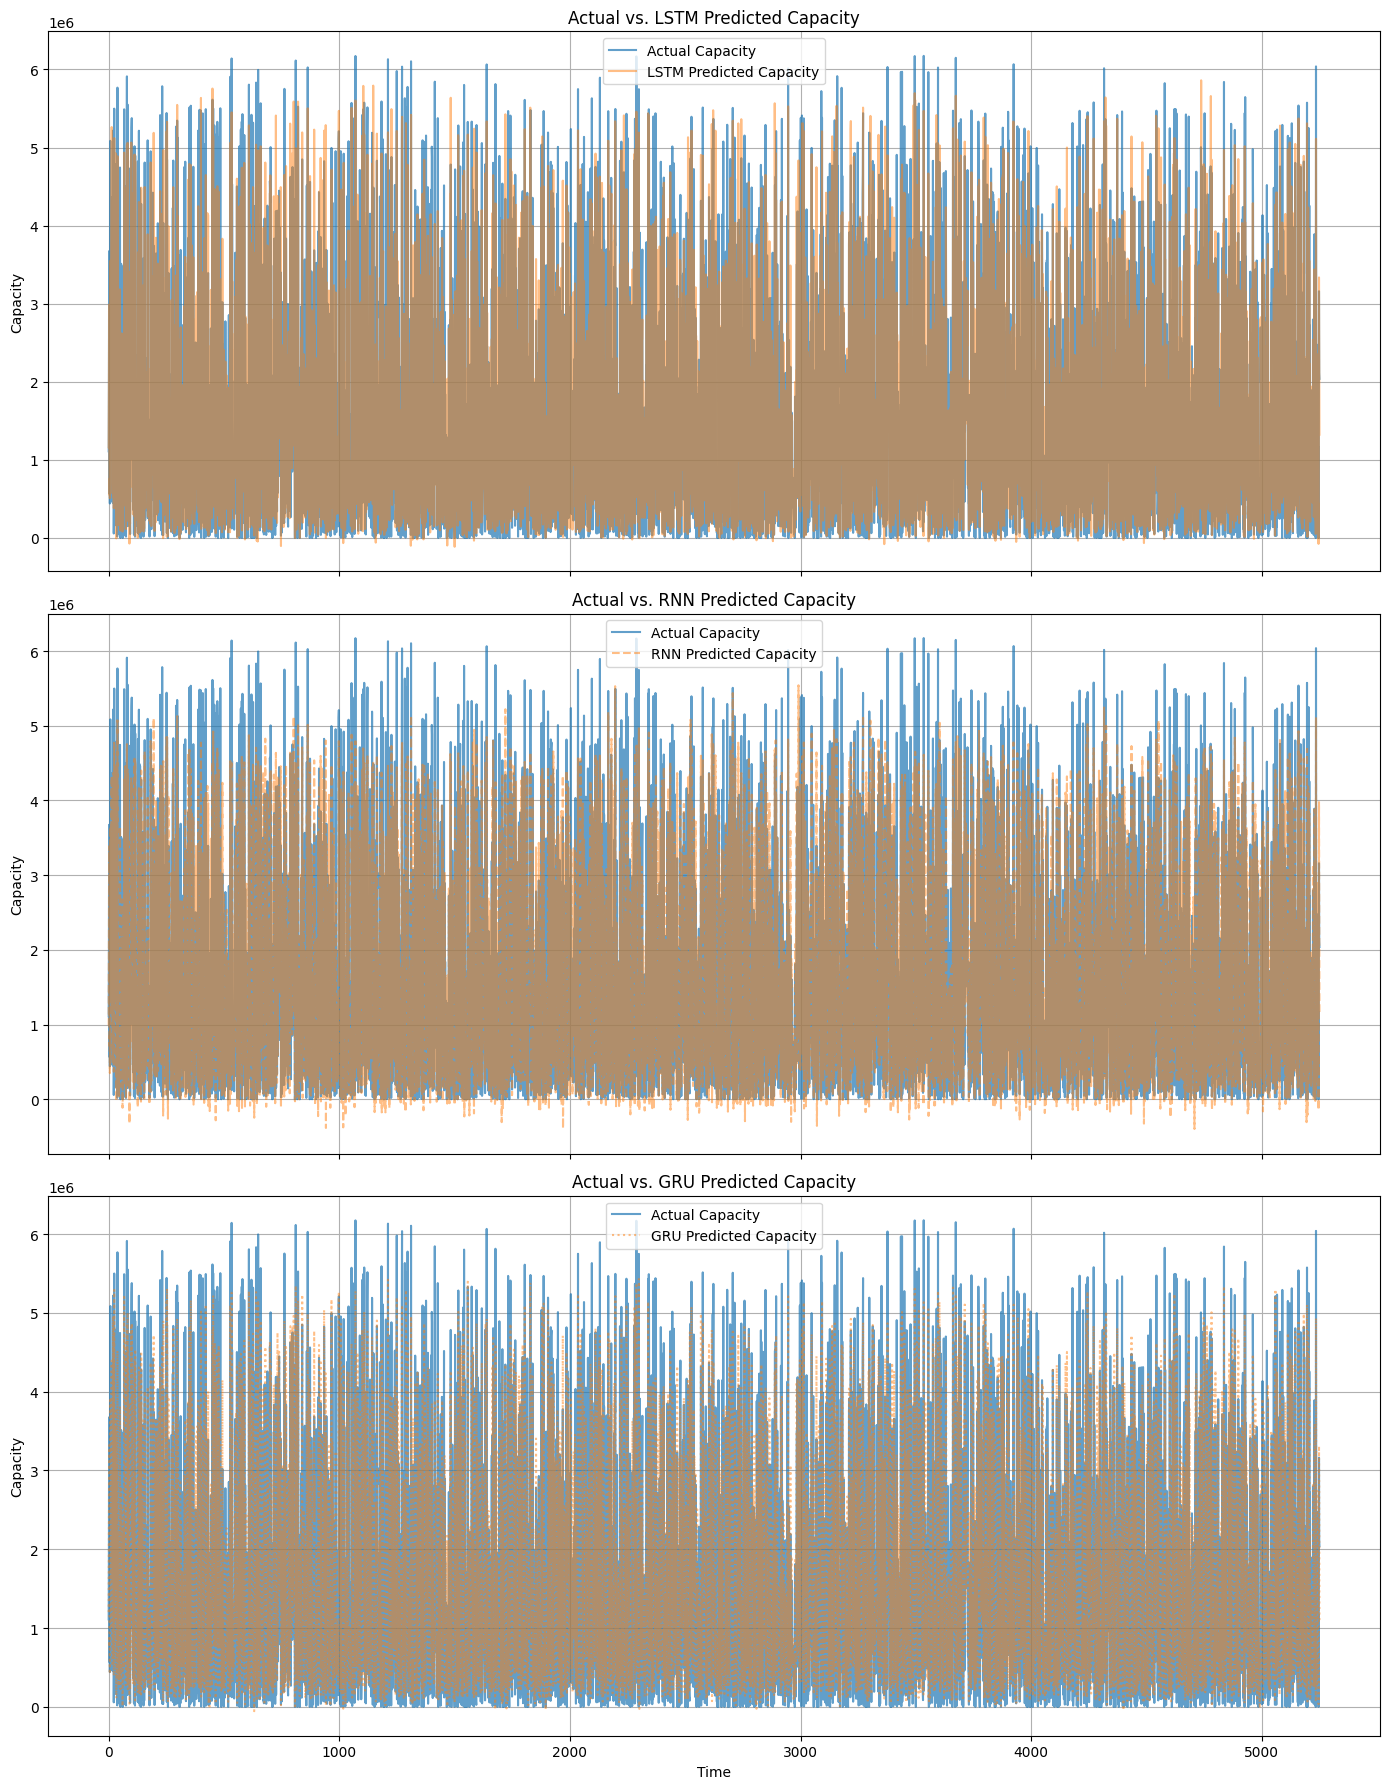

In [51]:
fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Plot Actual vs LSTM Predictions
axs[0].plot(actual_capacity, label='Actual Capacity', color='grey', alpha=0.9, linewidth=2)
axs[0].plot(predicted_capacity, label='LSTM Predicted Capacity', color='blue', alpha=0.5, linewidth=2)
axs[0].set_title('Actual vs. LSTM Predicted Capacity', fontsize=14, fontweight='bold')
axs[0].set_ylabel('Capacity', fontsize=12)
axs[0].legend(fontsize=12)
axs[0].grid(True, alpha=0.5)

# Plot Actual vs RNN Predictions
axs[1].plot(actual_capacity, label='Actual Capacity', color='grey', alpha=0.9, linewidth=2)
axs[1].plot(predicted_rnn_capacity, label='RNN Predicted Capacity', color='green', alpha=0.5, linestyle='dashed', linewidth=2)
axs[1].set_title('Actual vs. RNN Predicted Capacity', fontsize=14, fontweight='bold')
axs[1].set_ylabel('Capacity', fontsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True, alpha=0.5)

# Plot Actual vs GRU Predictions
axs[2].plot(actual_capacity, label='Actual Capacity', color='grey', alpha=0.9, linewidth=2)
axs[2].plot(predicted_GRU_capacity, label='GRU Predicted Capacity', color='orange', alpha=0.5, linestyle='dotted', linewidth=2)
axs[2].set_title('Actual vs. GRU Predicted Capacity', fontsize=14, fontweight='bold')
axs[2].set_xlabel('Time', fontsize=12)
axs[2].set_ylabel('Capacity', fontsize=12)
axs[2].legend(fontsize=12)
axs[2].grid(True, alpha=0.5)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


this comfirms that the GRU makes more acurracte prediction in comparison to the orther 2. 

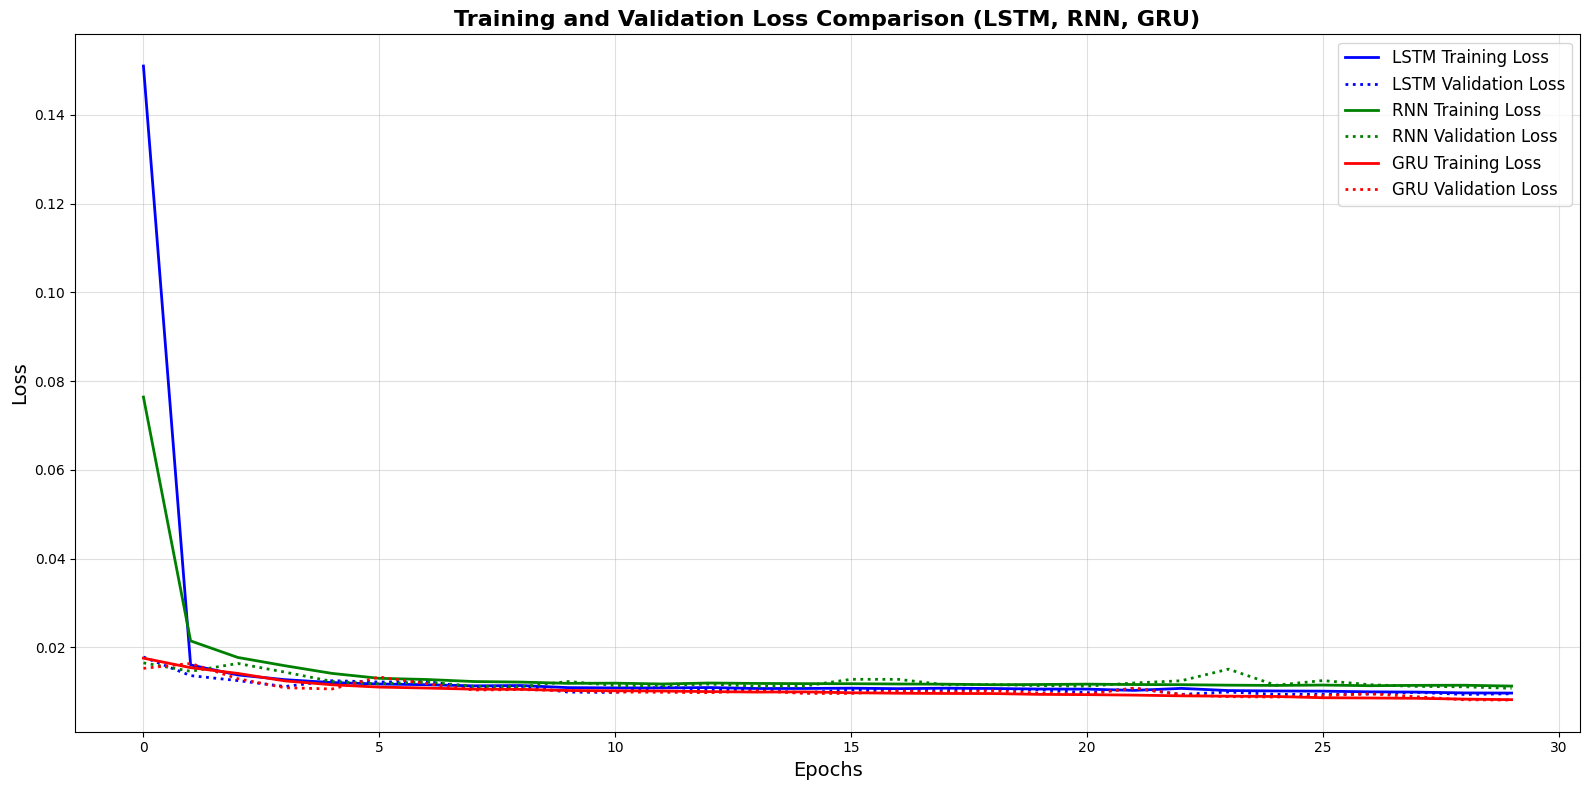

In [52]:
# Plot training and validation loss for LSTM, RNN, and GRU
plt.figure(figsize=(16, 8))

# LSTM Loss
plt.plot(history.history['loss'], label='LSTM Training Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='LSTM Validation Loss', color='blue', linestyle='dotted', linewidth=2)

# RNN Loss
plt.plot(rnn_history.history['loss'], label='RNN Training Loss', color='green', linewidth=2)
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss', color='green', linestyle='dotted', linewidth=2)

# GRU Loss
plt.plot(GRU_history.history['loss'], label='GRU Training Loss', color='red', linewidth=2)
plt.plot(GRU_history.history['val_loss'], label='GRU Validation Loss', color='red', linestyle='dotted', linewidth=2)

# Titles and labels
plt.title('Training and Validation Loss Comparison (LSTM, RNN, GRU)', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Legend
plt.legend(fontsize=12, loc='upper right', frameon=True)

# Grid and display
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


so looking at this graph we can see that the GRU runs the smoothes from all there models. which means it is also the most stable model. 

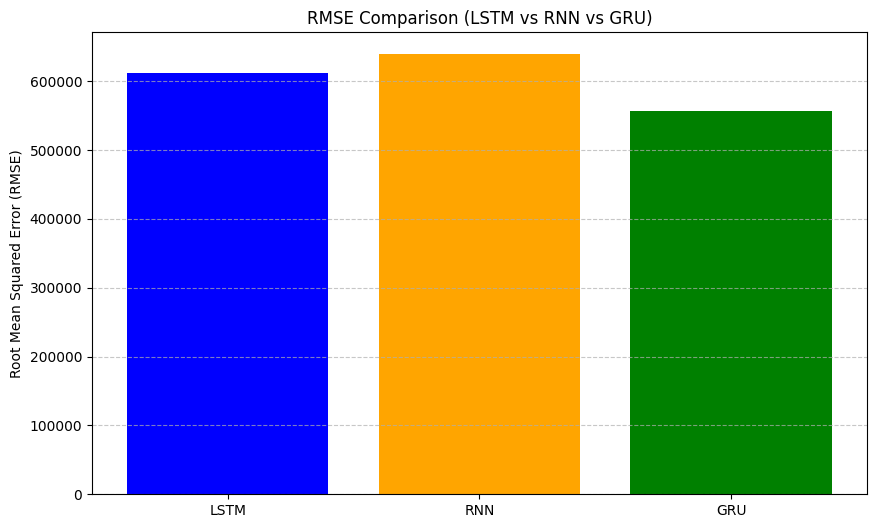

In [53]:
lstm_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_capacity))
rnn_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn_capacity))
GRU_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_GRU_capacity))
# Create a bar plot
models = ['LSTM', 'RNN', 'GRU']
rmse_values = [lstm_rmse, rnn_rmse, GRU_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.title('RMSE Comparison (LSTM vs RNN vs GRU)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The average error margin of the GRU is lower then that of the other 2 

### Optuna trials

after seeing that the GRU model is the best predicting model its time to see if it can be further improved. we first tried doing this with a gridsearch which took way to long to run (over 48 hours). that is when we decided to see if we could find a way to get the same result but in a way that would cosume less time. 

this is when we came across optuna trials. optuna trials is comparable with a gridsearch. However where a gridsearch will run every possible combination of hyperparameters optuna trials will adjust based on results. this means that when a trial fails it doesn't waste time on running it anyway. You can also control the run time by setting the max number of trials it wil run. 

This method reduces training time significantly to where the gridsearch took more as 48 hours and the optuna trials below took max 2 hours. 

> https://medium.com/data-and-beyond/master-the-power-of-optuna-a-step-by-step-guide-ed43500e9b95 

In [54]:
# Function to create RNN model with parameters
def create_GRU_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    # First RNN layer
    model.add(GRU(units, return_sequences=(layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))

    # Additional RNN layers with Dropout
    for i in range(1, layers):
        model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize K-Fold cross-validation on the training set
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters to optimize
    units = trial.suggest_categorical('units', [64, 128, 256])
    layers = trial.suggest_int('layers', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create the model with the suggested hyperparameters
    model = create_GRU_model(units, layers, dropout_rate, learning_rate)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    fold_scores = []
    for train_index, val_index in kf.split(np.arange(len(X_train))):
        # Split data
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Train model with early stopping
        model.fit(X_fold_train, y_fold_train, epochs=30, batch_size=batch_size,
                  validation_data=(X_fold_val, y_fold_val), verbose=0, callbacks=[early_stopping])

        # Predict and evaluate on validation fold
        y_pred = model.predict(X_fold_val).squeeze()
        fold_r2 = r2_score(y_fold_val, y_pred)
        fold_scores.append(fold_r2)

    # Return the mean R² score for this trial
    return np.mean(fold_scores)

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Print the best results
print("\nBest Hyperparameters:", study.best_params)


[I 2025-01-20 17:05:20,364] A new study created in memory with name: no-name-3c92f384-75c6-408d-9bd4-5b9b3d2b2957
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


[I 2025-01-20 17:08:58,533] Trial 0 finished with value: 0.835687152890523 and parameters: {'units': 64, 'layers': 4, 'dropout_rate': 0.30552356789484125, 'learning_rate': 0.00030166660663023223, 'batch_size': 32}. Best is trial 0 with value: 0.835687152890523.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 17:11:55,163] Trial 1 finished with value: 0.8451834857823818 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.3438254822743099, 'learning_rate': 0.00041011123658171733, 'batch_size': 32}. Best is trial 1 with value: 0.8451834857823818.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-01-20 17:19:43,767] Trial 2 finished with value: 0.8409329180503251 and parameters: {'units': 256, 'layers': 4, 'dropout_rate': 0.3080506282519856, 'learning_rate': 0.0007693011603333728, 'batch_size': 32}. Best is trial 1 with value: 0.8451834857823818.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-01-20 17:24:02,964] Trial 3 finished with value: 0.8230781464069503 and parameters: {'units': 256, 'layers': 4, 'dropout_rate': 0.194561112744296, 'learning_rate': 0.001783703853021103, 'batch_size': 64}. Best is trial 1 with value: 0.8451834857823818.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 17:26:22,482] Trial 4 finished with value: 0.8154133533858299 and parameters: {'units': 128, 'layers': 3, 'dropout_rate': 0.12451596468726925, 'learning_rate': 0.00011275963400970305, 'batch_size': 128}. Best is trial 1 with value: 0.8451834857823818.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 17:29:28,302] Trial 5 finished with value: 0.8338713455277508 and parameters: {'units': 64, 'layers': 3, 'dropout_rate': 0.10550686933143921, 'learning_rate': 0.0001373942176671295, 'batch_size': 32}. Best is trial 1 with value: 0.8451834857823818.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 17:30:51,247] Trial 6 finished with value: 0.8655271573253405 and parameters: {'units': 128, 'layers': 1, 'dropout_rate': 0.15483816142071688, 'learning_rate': 0.0009890425061453445, 'batch_size': 128}. Best is trial 6 with value: 0.8655271573253405.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 17:32:31,216] Trial 7 finished with value: 0.883337823790575 and parameters: {'units': 128, 'layers': 1, 'dropout_rate': 0.23868954524464422, 'learning_rate': 0.001307565899068691, 'batch_size': 128}. Best is trial 7 with value: 0.883337823790575.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 17:37:25,764] Trial 8 finished with value: 0.9102581540199512 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.3444124275357706, 'learning_rate': 0.001035583304879343, 'batch_size': 32}. Best is trial 8 with value: 0.9102581540199512.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


[I 2025-01-20 17:43:36,626] Trial 9 finished with value: -0.0029329617738877247 and parameters: {'units': 256, 'layers': 4, 'dropout_rate': 0.38778181173592874, 'learning_rate': 0.005805574798268014, 'batch_size': 32}. Best is trial 8 with value: 0.9102581540199512.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-20 17:48:54,387] Trial 10 finished with value: 0.8951434555505972 and parameters: {'units': 256, 'layers': 2, 'dropout_rate': 0.3823751177610325, 'learning_rate': 0.0038725551792765586, 'batch_size': 64}. Best is trial 8 with value: 0.9102581540199512.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-20 17:51:21,927] Trial 11 finished with value: 0.8253240625272037 and parameters: {'units': 256, 'layers': 2, 'dropout_rate': 0.3999564198733415, 'learning_rate': 0.004730460428510802, 'batch_size': 64}. Best is trial 8 with value: 0.9102581540199512.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-20 17:54:29,482] Trial 12 finished with value: 0.8645877215941997 and parameters: {'units': 256, 'layers': 2, 'dropout_rate': 0.33970893376598515, 'learning_rate': 0.0032790380309320553, 'batch_size': 64}. Best is trial 8 with value: 0.9102581540199512.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


[I 2025-01-20 17:56:59,164] Trial 13 finished with value: 0.8453746323821606 and parameters: {'units': 256, 'layers': 2, 'dropout_rate': 0.27178237938215555, 'learning_rate': 0.002644486016786544, 'batch_size': 64}. Best is trial 8 with value: 0.9102581540199512.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 18:00:14,677] Trial 14 finished with value: 0.9365964363856212 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.36113195979713913, 'learning_rate': 0.006707329208935261, 'batch_size': 64}. Best is trial 14 with value: 0.9365964363856212.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 18:02:40,040] Trial 15 finished with value: 0.8500689762444021 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.34087622859644773, 'learning_rate': 0.009786683125080653, 'batch_size': 32}. Best is trial 14 with value: 0.9365964363856212.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


[I 2025-01-20 18:09:20,263] Trial 16 finished with value: 0.8222551964705018 and parameters: {'units': 256, 'layers': 5, 'dropout_rate': 0.2562306520408365, 'learning_rate': 0.0005213417026269913, 'batch_size': 64}. Best is trial 14 with value: 0.9365964363856212.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-01-20 18:12:27,277] Trial 17 finished with value: 0.8627434758728435 and parameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.29714907630172793, 'learning_rate': 0.009025519593119247, 'batch_size': 32}. Best is trial 14 with value: 0.9365964363856212.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2025-01-20 18:13:46,593] Trial 18 finished with value: 0.8441352566202736 and parameters: {'units': 128, 'layers': 1, 'dropout_rate': 0.21236294946464024, 'learning_rate': 0.00022433846319709933, 'batch_size': 64}. Best is trial 14 with value: 0.9365964363856212.
c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2025-01-20 18:14:56,358] Trial 19 finished with value: 0.8500892876102544 and parameters: {'units': 64, 'layers': 2, 'dropout_rate': 0.35723047011020787, 'learning_rate': 0.0020792614112539946, 'batch_size': 128}. Best is trial 14 with value: 0.9365964363856212.



Best Hyperparameters: {'units': 256, 'layers': 1, 'dropout_rate': 0.36113195979713913, 'learning_rate': 0.006707329208935261, 'batch_size': 64}


now that we found the best parameters we can train the final model and see the results.  

In [55]:
# Train the best model on the entire training set with the best hyperparameters
best_params = study.best_params

# Remove 'batch_size' from the parameters passed to create_rnn_model
final_model = create_GRU_model(units=best_params['units'], 
                                layers=best_params['layers'], 
                                dropout_rate=best_params['dropout_rate'], 
                                learning_rate=best_params['learning_rate'])

# Train the model
final_history = final_model.fit(X_train, y_train, epochs=30, batch_size=best_params['batch_size'],validation_split=0.2,verbose=0)

# Predict on the test set
y_test_pred = final_model.predict(X_test).squeeze()
test_r2 = r2_score(y_test, y_test_pred)

train_predictions = final_model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)

# Print final evaluation
print(f"\nFinal R² Score on the training set: {train_r2:.4f}")
print(f"\nFinal R² Score on the test set: {test_r2:.4f}")

c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Final R² Score on the training set: 0.9487

Final R² Score on the test set: 0.9291


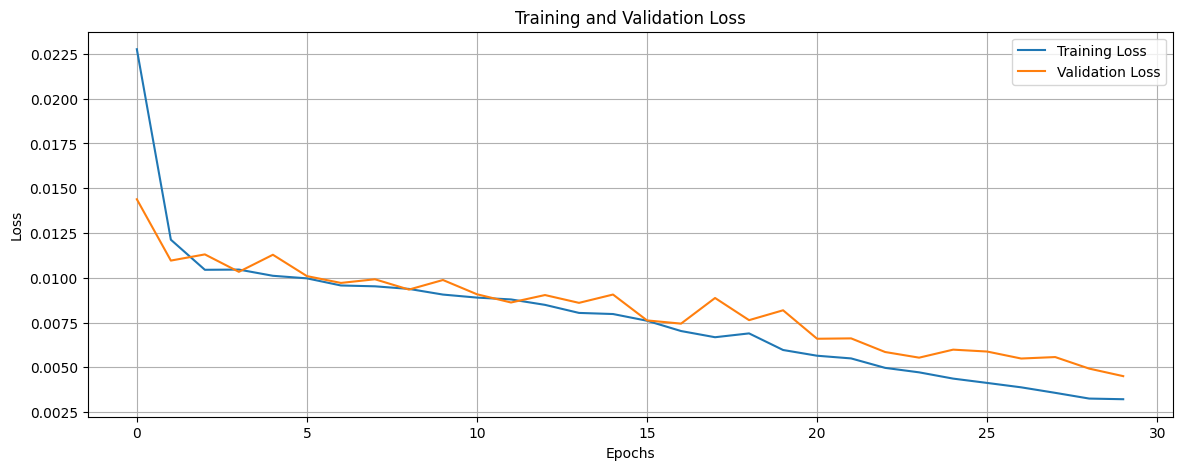

In [57]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(final_history.history['loss'], label='Training Loss')
plt.plot(final_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

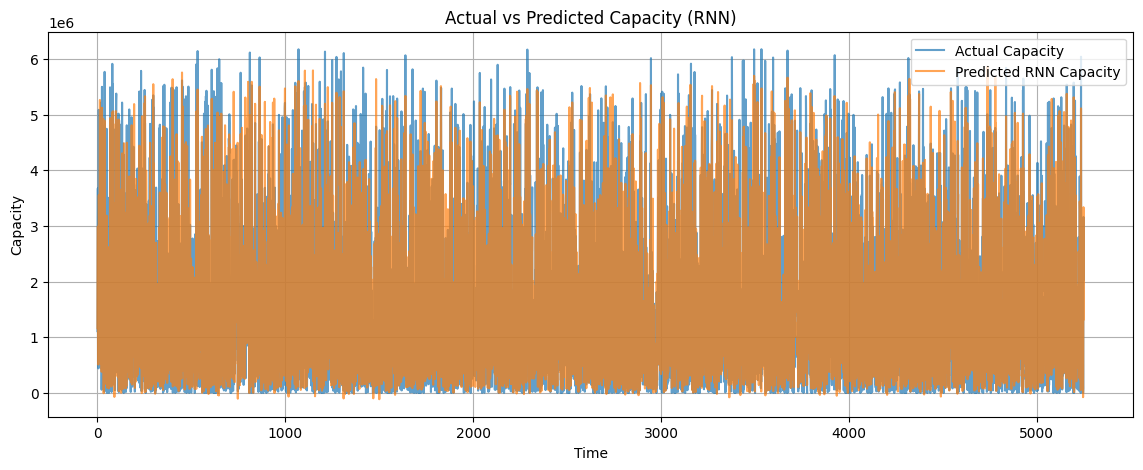

In [56]:
# Inverse transform predictions and actual values
predicted_final_capacity = target_scaler.inverse_transform(y_test_pred.reshape(-1, 1))
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

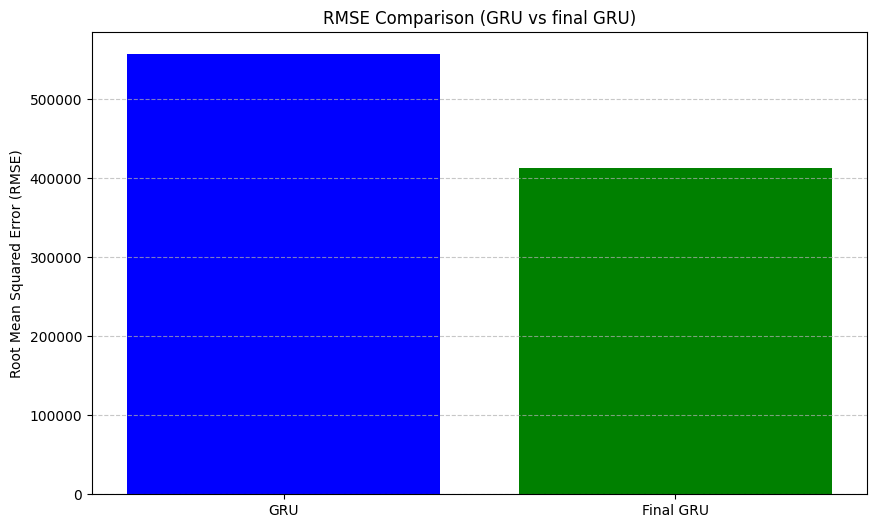

In [58]:
final_GRU_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_final_capacity))
# Create a bar plot
models = ['GRU', 'Final GRU']
rmse_values = [GRU_rmse, final_GRU_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'green'])
plt.title('RMSE Comparison (GRU vs final GRU)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

the final GRU is actually not better then the first. it might be bit less over fitted but with that we also got a lower R². 

## conclusion

The best preforming model wast the first GRU we trained. we eventually looked at if we could improve the models R² with hyper parameter tuning using optuna trial. with this we ended up with a less overfitted model but the R² was also lower. 

Since the First GRU model was not significantly overfitted, the optuna trials did not benefit the model. 

Ofcourse there would still be ways to improve. this could be doneby adding more years since we are only using 2021 through 2023. but also by finding production data that is devided in regions. this way we can look more precise per region as wel. 

now we use weather data from the bilt because it is central in the netherlands. 